In [44]:
#!/usr/bin/env python
"""
Creates lists of molecules on a grid.

Hazen 12/16
"""

import argparse
import random
import numpy as np

import storm_analysis.sa_library.i3dtype as i3dtype
import storm_analysis.sa_library.writeinsight3 as writeinsight3

"""
parser = argparse.ArgumentParser(description = "Create a grid of emitters for simulations.")

parser.add_argument('--bin', dest='i3bin', type=str, required=True,
                    help = "The name of Insight3 format file to save the emitter locations, etc.")
parser.add_argument('--nx', dest='nx', type=int, required=True,
                    help = "The grid size in X.")
parser.add_argument('--ny', dest='ny', type=int, required=True,
                    help = "The grid size in Y.")
parser.add_argument('--zrange', dest='zrange', type=float, required=False, default = 0.0,
                    help = "Range for z values in nm, -zrange to zrange")

args = parser.parse_args()
"""
random.seed(0)

nx = 30
ny = 30
z_range = 100
i3bin = 'i3_helix.bin'

if (nx*ny > 1):
    curz = -z_range
    z_inc = 2.0 * z_range/(nx*ny - 1)
else:
    curz = 0.0
    z_inc = 0.0

i3data = i3dtype.createDefaultI3Data(nx * ny)

theta_max = 4 * np.pi
theta = np.linspace(0, theta_max, nx*ny)
x = np.sin(theta) * 100 + 100
y =  np.cos(theta) * 100 + 100
z =  theta

for i in range(nx):
    for j in range(ny):
        k = i*ny+j   
        i3data['x'][k] = x[k]
        i3data['y'][k] = y[k]
        i3data['z'][k] = z[k]
        
        i3data['xc'][k] = i3data['x'][k]
        i3data['yc'][k] = i3data['y'][k]
        i3data['zc'][k] = i3data['z'][k]

        # Record emitter id in the 'i' field.
        i3data['i'][k] = k

with writeinsight3.I3Writer(i3bin) as i3w:
    i3w.addMolecules(i3data)

('Added', 900)


In [45]:
print(i3data['x'])
print(i3data['y'])
print(i3data['z'])

[  1.00000000e+02   1.01397774e+02   1.02795265e+02   1.04192223e+02
   1.05588356e+02   1.06983391e+02   1.08377068e+02   1.09769112e+02
   1.11159241e+02   1.12547188e+02   1.13932693e+02   1.15315468e+02
   1.16695251e+02   1.18071770e+02   1.19444763e+02   1.20813957e+02
   1.22179085e+02   1.23539871e+02   1.24896065e+02   1.26247391e+02
   1.27593590e+02   1.28934402e+02   1.30269562e+02   1.31598801e+02
   1.32921860e+02   1.34238495e+02   1.35548447e+02   1.36851440e+02
   1.38147247e+02   1.39435593e+02   1.40716232e+02   1.41988907e+02
   1.43253387e+02   1.44509415e+02   1.45756760e+02   1.46995148e+02
   1.48224350e+02   1.49444138e+02   1.50654266e+02   1.51854507e+02
   1.53044601e+02   1.54224335e+02   1.55393478e+02   1.56551788e+02
   1.57699066e+02   1.58835052e+02   1.59959549e+02   1.61072342e+02
   1.62173187e+02   1.63261887e+02   1.64338226e+02   1.65402008e+02
   1.66452988e+02   1.67490997e+02   1.68515823e+02   1.69527252e+02
   1.70525116e+02   1.71509186e+02

<IPython.core.display.Javascript object>


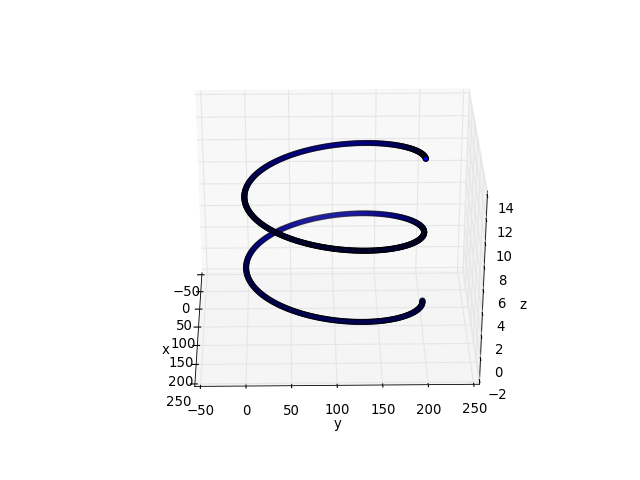

In [46]:
%matplotlib notebook

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
X, Y, Z = axes3d.get_test_data(0.1)
ax.scatter(i3data['x'], i3data['y'], i3data['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()

In [47]:
#!/usr/bin/env python
"""
Generate simulated. The basic idea is that you provide a list of
localizations in Insight3 .bin format and these are used to
generate a series of images using the following steps:

Initialization:
  1. locs = readinsight3.loadI3File()
  2. bg = background.Background()
  3. camera = camera.Camera()
  4. pp = photophysics.Photophysics()
  5. psf = psf.PSF()


Generation:
  1. image = numpy.zeros()
  2. image += bg.getBackground()
  3. cur_locs = pp.getEmitters()
  4. image += psf.getPSFs()
  5. image = camera.readImage()
  6. saveimage()
  7. savelocs()

Note: This is expected to set the 'h','a' and 'bg' fields in
    the output list to the correct values. The values 'x', 'y',
    'z', 'ax' and 'w' are just passed through. Other values
    such as 'i' are not set and are will likely be incorrect.

Hazen 11/16
"""

import json
import numpy

import storm_analysis.sa_library.daxwriter as daxwriter
import storm_analysis.sa_library.readinsight3 as readinsight3
import storm_analysis.sa_library.writeinsight3 as writeinsight3


class Simulate(object):

    def __init__(self, background_factory, camera_factory, photophysics_factory, psf_factory, x_size = 256, y_size = 256):
        """
        The factory variables should be functions that return the correct class
        to run a simulation with the following signature:

        factory_fn(sim_settings, x_size, y_size, i3_data_in)

        """
        self.bg_factory = background_factory
        self.cam_factory = camera_factory
        self.pphys_factory = photophysics_factory
        self.psf_factory = psf_factory
        self.x_size = x_size
        self.y_size = y_size

    def setBackgroundFactory(self, new_factory):
        self.bg_factory = new_factory

    def setCameraFactory(self, new_factory):
        self.cam_factory = new_factory

    def setPhotoPhysicsFactory(self, new_factory):
        self.pphys_factory = new_factory

    def setPSFFactory(self, new_factory):
        self.psf_factory = new_factory

    def simulate(self, dax_file, bin_file, n_frames):

        #
        # Initialization.
        #
        dax_data = daxwriter.DaxWriter(dax_file, self.x_size, self.y_size)
        i3_data_in = readinsight3.loadI3File(bin_file)

        out_fname_base = dax_file[:-4]
        i3_data_out = writeinsight3.I3Writer(out_fname_base + "_olist.bin")
        sim_settings = open(out_fname_base + "_sim_params.txt", "w")

        #
        # Create the user-specified class instances that will do
        # most of the actual work of the simulation.
        #
        bg = self.bg_factory(sim_settings, self.x_size, self.y_size, i3_data_in)
        cam = self.cam_factory(sim_settings, self.x_size, self.y_size, i3_data_in)
        pp = self.pphys_factory(sim_settings, self.x_size, self.y_size, i3_data_in)
        psf = self.psf_factory(sim_settings, self.x_size, self.y_size, i3_data_in)

        sim_settings.write(json.dumps({"simulation" : {"bin_file" : bin_file,
                                                       "x_size" : str(self.x_size),
                                                       "y_size" : str(self.y_size)}}) + "\n")

        images = numpy.zeros([n_frames, self.x_size, self.y_size])
        #
        # Generate the simulated movie.
        #
        for i in range(n_frames):

            # Generate the new image.
            image = numpy.zeros((self.x_size, self.y_size))
            cur_i3 = pp.getEmitters(i)

            print("Frame", i, cur_i3['x'].size, "emitters")

            # Background
            image += bg.getBackground(i)
            cur_i3 = bg.getEmitterBackground(cur_i3)

            # Foreground
            image += psf.getPSFs(cur_i3)

            # Camera
            image = cam.readImage(image)

            # Save the image.
            dax_data.addFrame(image)

            # Save the molecule locations.
            cur_i3['fr'] = i + 1
            i3_data_out.addMolecules(cur_i3)
            images[i] = image

        dax_data.close()
        i3_data_out.close()
        sim_settings.close()
        return images

In [48]:
import tifffile

#!/usr/bin/env python
import storm_analysis

import storm_analysis.simulator.background as background
import storm_analysis.simulator.camera as camera
import storm_analysis.simulator.photophysics as photophysics
import storm_analysis.simulator.psf as psf

dax_name = "test_sim_helix.dax"
bin_name = "i3_helix.bin"

sim = Simulate(lambda settings, xs, ys, i3data : background.UniformBackground(settings, xs, ys, i3data, photons = 20),
               lambda settings, xs, ys, i3data : camera.EMCCD(settings, xs, ys, i3data, 100.0, emccd_gain = 5.0, preamp_gain = 1.0, read_noise = 5),
               lambda settings, xs, ys, i3data : photophysics.SimpleSTORM(settings, xs, ys, i3data, 4000.0, off_time = 10.0),
               lambda settings, xs, ys, i3data : psf.PupilFunction(settings, xs, ys, i3data, 100.0, [[1.3, 2, 2]]),
               x_size = 201, y_size = 201)
                   
images = sim.simulate(dax_name, bin_name, 10)
tifffile.imsave('sample_helix.tiff', images)

('Version:', 'M425')
('Frames:', 1)
('Status:', 6)
('Molecules:', 900)

('psf size', 40)
('Frame', 0, 80, 'emitters')
('Frame', 1, 103, 'emitters')
('Frame', 2, 151, 'emitters')
('Frame', 3, 155, 'emitters')
('Frame', 4, 166, 'emitters')
('Frame', 5, 163, 'emitters')
('Frame', 6, 165, 'emitters')
('Frame', 7, 171, 'emitters')
('Frame', 8, 152, 'emitters')
('Frame', 9, 183, 'emitters')
('Added', 1489)
